
## ABOUT THE DATA

The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required,
in order to access if the product (bank term deposit) would be (or not) subscribed.

age (numeric)
job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services")

marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

education (categorical: "unknown","secondary","primary","tertiary")

default: has credit in default? (binary: "yes","no")

balance: average yearly balance, in euros (numeric)

housing: has housing loan? (binary: "yes","no")

loan: has personal loan? (binary: "yes","no")


related with the last contact of the current campaign:


contact: contact communication type (categorical: "unknown","telephone","cellular")

day: last contact day of the month (numeric)

month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")
duration: last contact duration, in seconds (numeric)


other attributes:

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

previous: number of contacts performed before this campaign and for this client (numeric)

poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):
y - has the client subscribed a term deposit? (binary: "yes", "no")


In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import joblib
from sklearn.decomposition import PCA

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

from keras.utils import to_categorical
from sklearn import metrics
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler


from scipy.stats import randint
from sklearn.model_selection import GridSearchCV

from kerastuner import HyperModel, HyperParameters, RandomSearch
from tensorflow import keras


from tensorflow.keras import layers
from sklearn.metrics import classification_report,confusion_matrix
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).


In [3]:

from google.colab import files

uploaded = files.upload()

Saving bank.csv to bank.csv


In [30]:
import io
data = io.BytesIO(uploaded['bank.csv'])

In [31]:
df = pd.read_csv(data)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [32]:
df.shape

(11162, 17)

dataset has 11,162 rows and 17 columns

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [34]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [35]:
df.isna().sum().sum()

0

In [36]:
df.duplicated().value_counts()

False    11162
dtype: int64

There are no duplicates, no null values

goal is to Predict the Likelihood of Term Deposit Subscriptions in Direct Marketing Campaigns

In [37]:
df['deposit']

0        yes
1        yes
2        yes
3        yes
4        yes
        ... 
11157     no
11158     no
11159     no
11160     no
11161     no
Name: deposit, Length: 11162, dtype: object

In [38]:
Deposit = []

for value in df['deposit']:
  if value =='yes':
    Deposit.append(1)
  else:
      Deposit.append(0)
df['Deposit'] = Deposit
df = df.drop(['deposit'], axis = 1)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


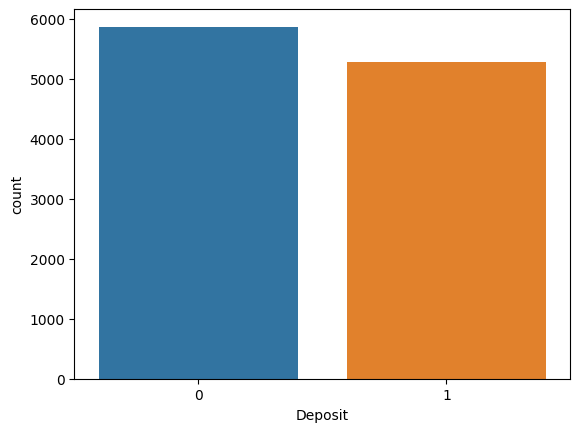

In [39]:
# countplot of the target variable
sns.countplot(x = df['Deposit']);

In [40]:
df['Deposit'].value_counts()

0    5873
1    5289
Name: Deposit, dtype: int64

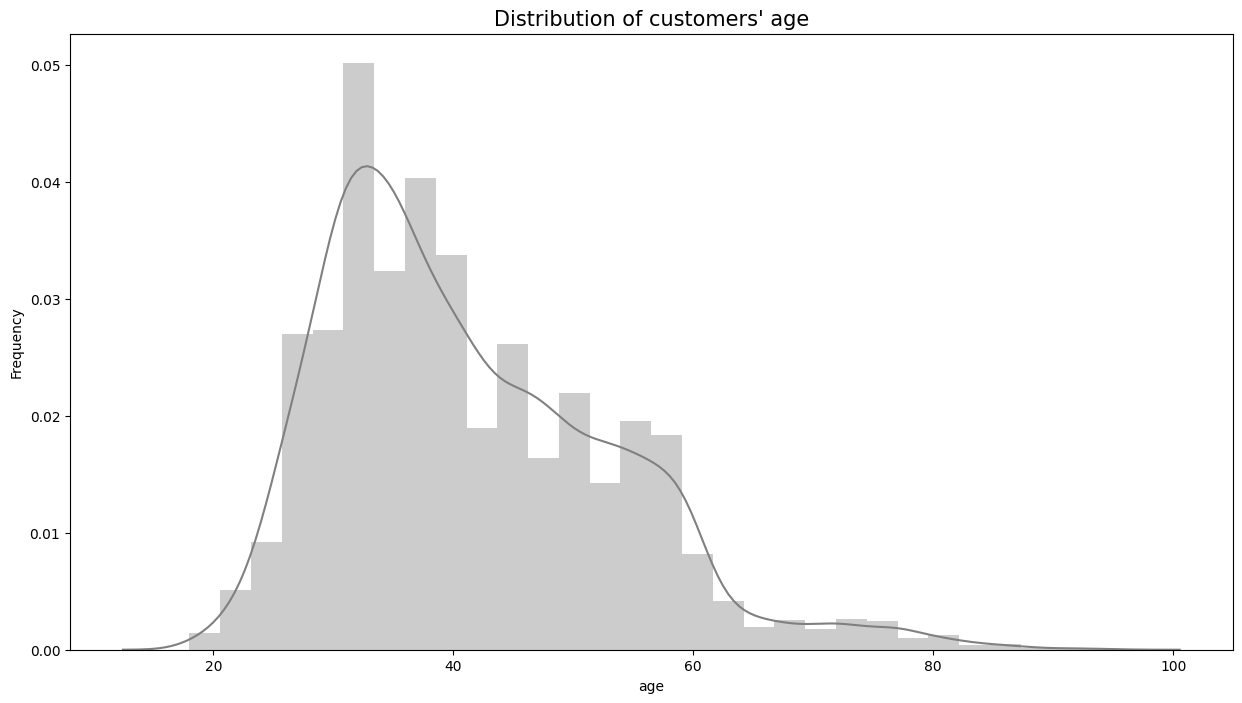

In [41]:
plt.figure(figsize=(15,8))
sns.distplot(df['age'], hist=True, bins=30, color='grey')
plt.xlabel('age')
plt.ylabel('Frequency')
plt.title("Distribution of customers' age", fontsize=15)
plt.show();

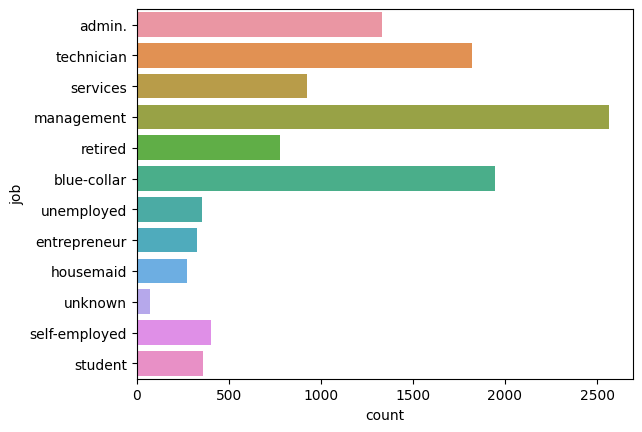

In [42]:
sns.countplot(y = df['job']);

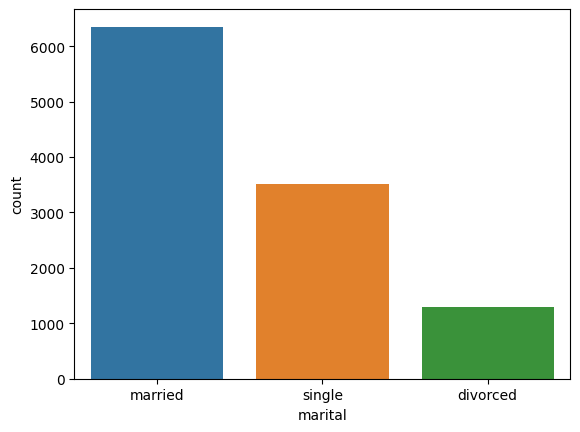

In [43]:
sns.countplot(x = df['marital']);

<Axes: xlabel='education', ylabel='count'>

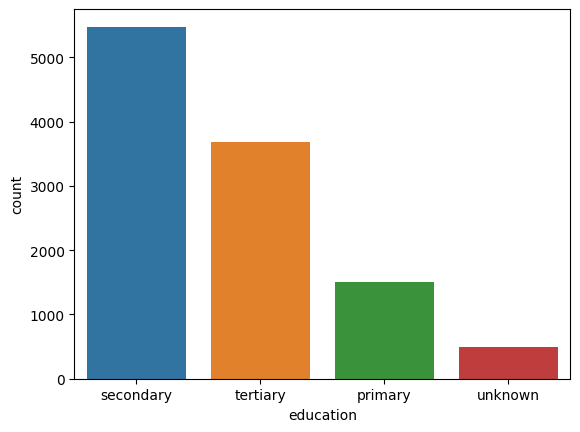

In [44]:
sns.countplot(x = df['education'])

In [45]:
sns.countplot

<function seaborn.categorical.countplot(data=None, *, x=None, y=None, hue=None, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, width=0.8, dodge=True, ax=None, **kwargs)>

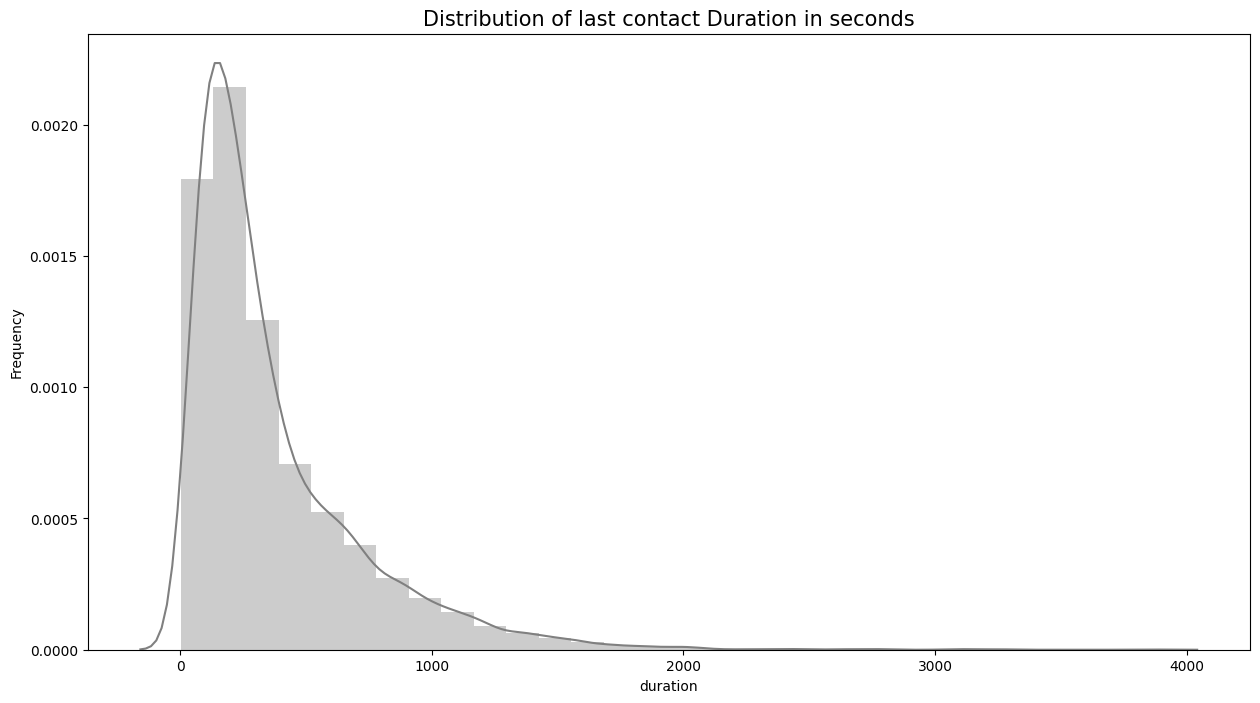

In [46]:
plt.figure(figsize=(15,8))
sns.distplot(df['duration'], hist=True, bins=30, color='grey')
plt.xlabel('duration')
plt.ylabel('Frequency')
plt.title("Distribution of last contact Duration in seconds", fontsize=15)
plt.show();

FEATURE SELECTION AND SCALING

in this section, the right features for predicting the deposit subscriptions will be carefully selscted with insights gotten

In [47]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


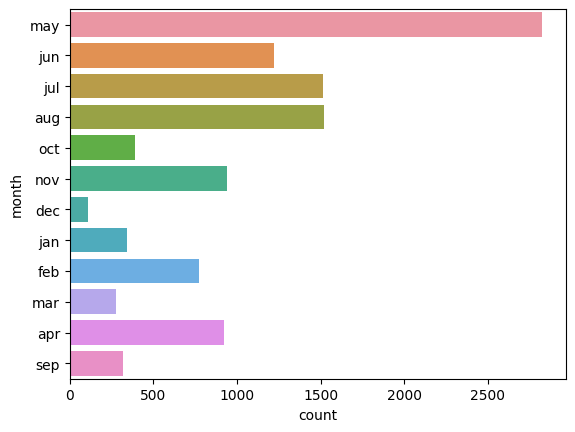

In [48]:
sns.countplot(y = df['month']);

as seen above the month with the highest count is may. Let's see of this has effect on the target variable

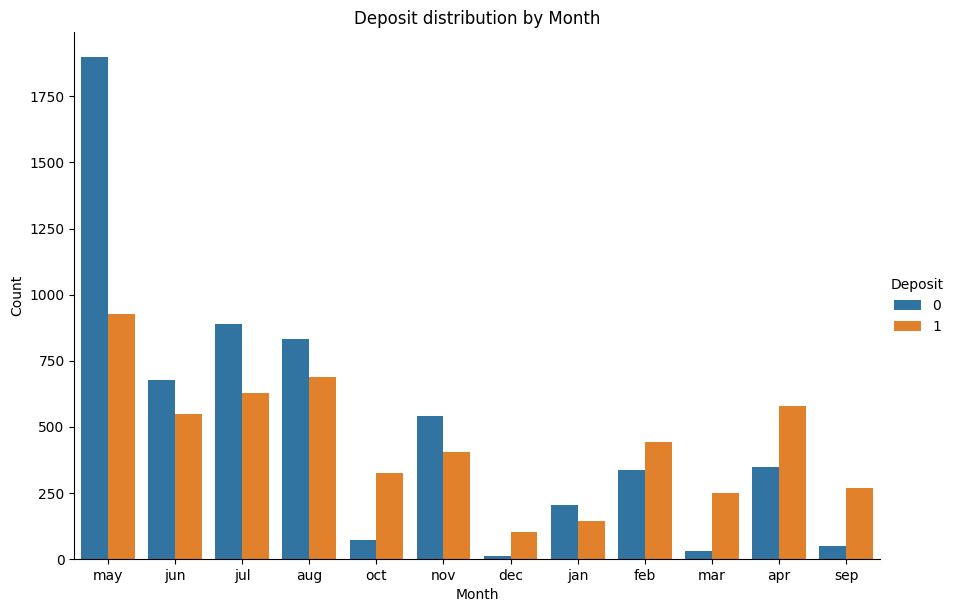

In [49]:
# Use catplot to create the bar plot
sns.catplot(x='month', hue='Deposit', data=df, kind='count', height=6, aspect=1.5)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Deposit distribution by Month')

# Show the plot
plt.show()

The month of may had the highest number of customers reach out to, yet the number of customers  that didn't subscribe were more than those that subscribed.
And overall, the month of may still had the highest number of subscribers.
To a good extent, it can be useful to include month as a feature in the model training

In [50]:
#drop column
df = df.drop(['day'], axis = 1)

Encoding categorical columns

In [51]:
encoder = LabelEncoder()
columns = ['job','marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
for column in columns:
  df[column] = encoder.fit_transform(df[column])

In [52]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,Deposit
0,59,0,1,1,0,2343,1,0,2,8,1042,1,-1,0,3,1
1,56,0,1,1,0,45,0,0,2,8,1467,1,-1,0,3,1
2,41,9,1,1,0,1270,1,0,2,8,1389,1,-1,0,3,1
3,55,7,1,1,0,2476,1,0,2,8,579,1,-1,0,3,1
4,54,0,1,2,0,184,0,0,2,8,673,2,-1,0,3,1


In [53]:
#function to plot distribution plots of the columns
def plot_dist_plots(dataframe):
    num_cols = len(dataframe.columns)
    num_rows = (num_cols // 4) + 1

    fig = plt.figure(figsize=(18, 12))
    fig.suptitle("Distribution Plots", fontsize='x-large', weight='extra bold', ha='center')

    for i, column in enumerate(dataframe.columns):
        plt.subplot(num_rows, 4, i+1)
        sns.distplot(dataframe[column], color='green')

    plt.tight_layout()
    plt.show()


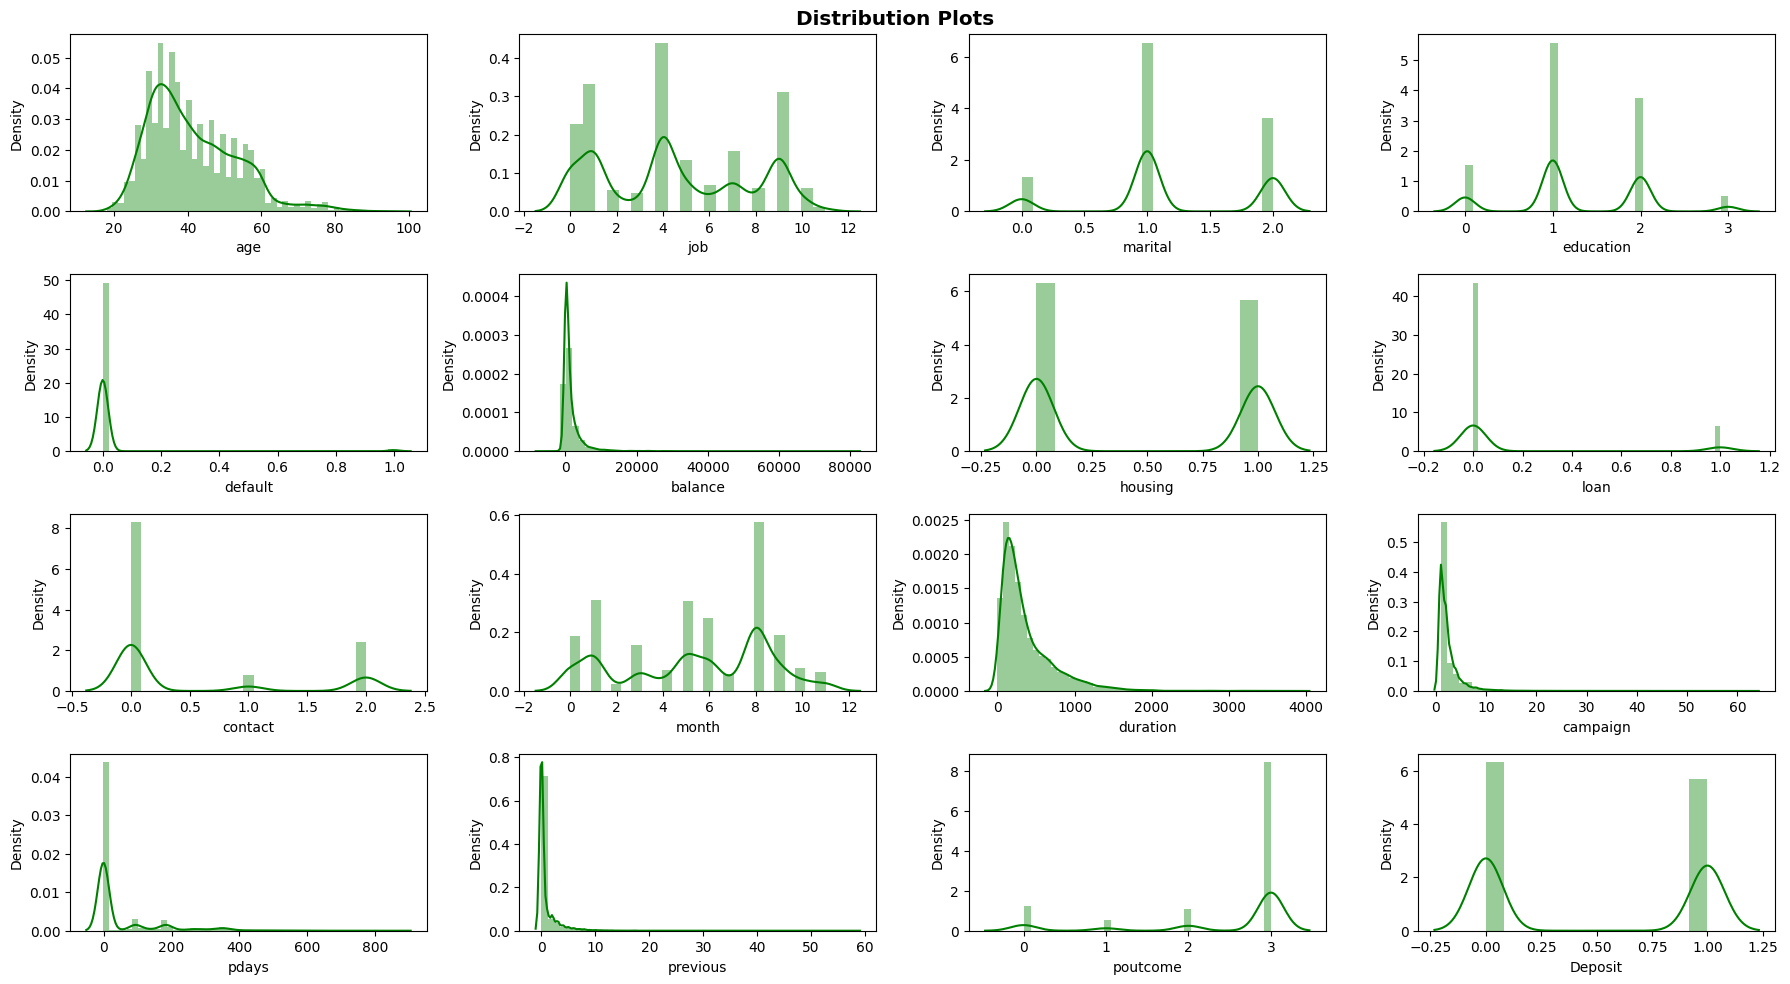

In [54]:
plot_dist_plots(df)

In [56]:
#split dataset
x = df.drop(['Deposit'], axis = 1)
y = df['Deposit']

ADDRESSING IMBALANCE IN THE TARGET CLASS

In [190]:
#Oversampling of the minority class in the target column

oversample = RandomOverSampler(sampling_strategy='not majority')
x_sampled, y_sampled = oversample.fit_resample(x, y)

x = x_sampled
y = y_sampled

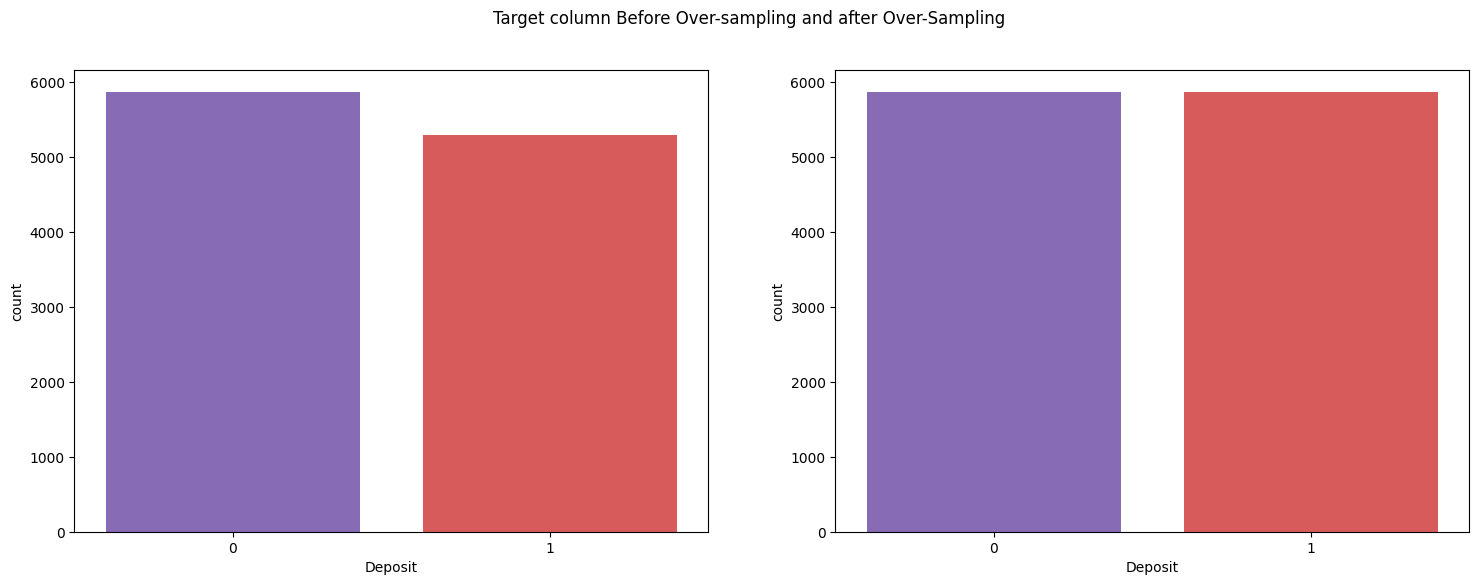

In [192]:
#visualize the oversampling results
plt.figure(figsize=(18,6))
plt.suptitle('Target column Before Over-sampling and after Over-Sampling')
plt.subplot(1,2,1)
sns.countplot(x = df['Deposit'], palette=['#845ec2','#ec4646','#00af91'])
plt.subplot(1,2,2)
sns.countplot(data=pd.DataFrame(y),x = 'Deposit', palette=['#845ec2','#ec4646','#00af91'] )
plt.show()

In [193]:
#scale the input columns
#initialize scaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x = pd.DataFrame(x_scaled, columns=x.columns)

## MODEL TRAINING AND EVALUATION

In [194]:
#split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [195]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
log_pred = log_reg.predict(x_test)

print(confusion_matrix(y_test, log_pred))

[[1422  320]
 [ 395 1387]]


In [196]:
print(classification_report(y_test, log_pred))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1742
           1       0.81      0.78      0.80      1782

    accuracy                           0.80      3524
   macro avg       0.80      0.80      0.80      3524
weighted avg       0.80      0.80      0.80      3524



In [197]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)

print(confusion_matrix(y_test, rf_pred))

[[1421  321]
 [ 218 1564]]


In [198]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1742
           1       0.83      0.88      0.85      1782

    accuracy                           0.85      3524
   macro avg       0.85      0.85      0.85      3524
weighted avg       0.85      0.85      0.85      3524



In [199]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
gnb_pred = gnb.predict(x_test)

print(confusion_matrix(y_test, gnb_pred))

[[1251  491]
 [ 370 1412]]


In [200]:
print(classification_report(y_test, gnb_pred))

              precision    recall  f1-score   support

           0       0.77      0.72      0.74      1742
           1       0.74      0.79      0.77      1782

    accuracy                           0.76      3524
   macro avg       0.76      0.76      0.76      3524
weighted avg       0.76      0.76      0.76      3524



In [201]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)


# Get predictions on the test data
xgb_pred = xgb.predict(x_test)
print(confusion_matrix(y_test, xgb_pred))

[[1429  313]
 [ 221 1561]]


In [202]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1742
           1       0.83      0.88      0.85      1782

    accuracy                           0.85      3524
   macro avg       0.85      0.85      0.85      3524
weighted avg       0.85      0.85      0.85      3524



## MODEL OPTIMIZATION

Fine-tuning the classification threshold based on the Precision-Recall (PR) curve to optimize model performance.

In [203]:
print('log_reg precision:', round(metrics.precision_score(y_test, log_pred), 2))
print('rf precision:', round(metrics.precision_score(y_test, rf_pred), 2))
print('gnb precision:', round(metrics.precision_score(y_test, gnb_pred), 2))
print('xgb precision:', round(metrics.precision_score(y_test, xgb_pred), 2))



log_reg precision: 0.81
rf precision: 0.83
gnb precision: 0.74
xgb precision: 0.83


In [269]:
print('log_reg recall:', round(metrics.recall_score(y_test, log_pred), 2))
print('rf recall:', round(metrics.recall_score(y_test, rf_pred), 2))
print('gnb recall:', round(metrics.recall_score(y_test, gnb_pred), 2))
print('xgb recall:', round(metrics.recall_score(y_test, xgb_pred), 2))



log_reg recall: 0.78
rf recall: 0.88
gnb recall: 0.79
xgb recall: 0.88


# both xgboost and random forest classifier have the highest precision and recall score, we will perform optimization on xgboost classifier and the threshold will be fine-tuned based on the Precision-Recall (PR) curve to optimize model performance.

In [208]:
metrics.accuracy_score(y_test, xgb_pred)

0.8484676503972758

0.85 is a good model accuracy but it's not perfect enough as far as this case study is concerned.

why?

We want to minimize the chances of missing potential subscribers


In [209]:
confusion_matrix(y_test, xgb_pred)

array([[1429,  313],
       [ 221, 1561]])

In [210]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1742
           1       0.83      0.88      0.85      1782

    accuracy                           0.85      3524
   macro avg       0.85      0.85      0.85      3524
weighted avg       0.85      0.85      0.85      3524



plot a Precision-Recall curve with the training data to find a point with a better precsion

Plotting the Precision-Recall curve is a common technique to evaluate the performance of binary classification models. The curve shows how precision and recall change at different probability thresholds, helping to visualize the trade-off between the two metrics.

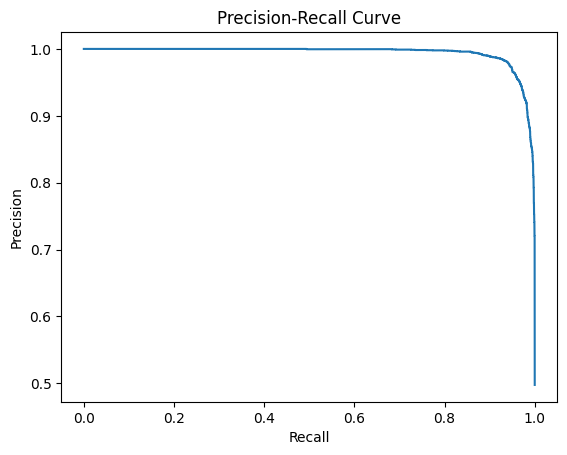

In [211]:
# Get predicted probabilities for the positive class (class 1) from the model
y_proba_train = xgb.predict_proba(x_train)[:, 1]

# Calculate precision, recall, and thresholds for different probability thresholds
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_proba_train)

# Plot the Precision-Recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [212]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):

  prt = np.array(list(zip(precision, recall, thresholds)))
  prt_df = pd.DataFrame(data=prt, columns=['Precision', 'Recall', 'Threshold'])
  print(prt_df)

      Precision    Recall  Threshold
0      0.497568  1.000000   0.000039
1      0.497628  1.000000   0.000057
2      0.497689  1.000000   0.000069
3      0.497749  1.000000   0.000076
4      0.497810  1.000000   0.000081
5      0.497870  1.000000   0.000087
6      0.497931  1.000000   0.000089
7      0.497991  1.000000   0.000094
8      0.498052  1.000000   0.000101
9      0.498113  1.000000   0.000102
10     0.498173  1.000000   0.000104
11     0.498234  1.000000   0.000107
12     0.498295  1.000000   0.000120
13     0.498355  1.000000   0.000135
14     0.498416  1.000000   0.000139
15     0.498477  1.000000   0.000142
16     0.498538  1.000000   0.000143
17     0.498598  1.000000   0.000147
18     0.498659  1.000000   0.000148
19     0.498720  1.000000   0.000155
20     0.498781  1.000000   0.000160
21     0.498842  1.000000   0.000162
22     0.498902  1.000000   0.000163
23     0.498963  1.000000   0.000169
24     0.499024  1.000000   0.000171
25     0.499085  1.000000   0.000171
2

Recall is a more relevant metric to take into account because the main objective is to correctly predict if a client will sign up for a term deposit.



Recall, also known as True Positive Rate or Sensitivity, gauges how well the model classifies actual positive cases (customers who signed up for a term deposit). In other words, it symbolizes the model's capacity to include all examples of success.

When recall is high, it indicates that the model is effectively minimizing the number of false negatives, i.e., the cases where the model incorrectly predicts that a client won't subscribe to a term deposit when they actually would.

This is essential in marketing campaigns since you don't want to miss out on potential customers who could be interested in signing up for a term deposit.

Contrarily, Precision quantifies the percentage of the model's favorable predictions that come true. It emphasizes the precision of optimistic forecasts. High precision optimization, meanwhile, might occasionally result in a rise in false negatives, which means losing out on potential subscribers. When the cost of false positives (predicting that a client would subscribe when they won't) is high, high precision is beneficial, but in this case, it's more important to prevent false negatives.






In [251]:
y_proba_test = xgb.predict_proba(x_test)[:, 1]
y_pred = (y_proba_test >= 0.236960).astype(int)
np.count_nonzero(y_pred)


2167

In [252]:

confusion_matrix(y_test, y_pred)

array([[1260,  482],
       [  97, 1685]])

In [253]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1742
           1       0.78      0.95      0.85      1782

    accuracy                           0.84      3524
   macro avg       0.85      0.83      0.83      3524
weighted avg       0.85      0.84      0.83      3524



## Hyper parameter Tuning

we are mostly concerned with the recall score improvement.. since the primary aim is to correctly predict that a client will subscribe to a term deposit (i.e., maximizing the True Positive rate), (class 1, subscribed to term deposit).

In [216]:
xgb_tune = XGBClassifier(n_estimators= 300, n_jobs= -1)
parameters = {'max_depth': range(5),
              'min_child_weight':[1,2,3,4,5],
              'reg_lambda': [0.50,0.75,1,1.25,1.5]}


grid = GridSearchCV(xgb_tune, param_grid = parameters, n_jobs= -1, cv = 5 )
grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=300, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(0, 5),
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'reg_lambda': [0.5, 0.75, 1, 1.25, 1.5]})

In [217]:
print ('Best parameters: {}'.format(grid.best_params_))

Best parameters: {'max_depth': 3, 'min_child_weight': 2, 'reg_lambda': 0.75}


POST TUNING WITH OPTIMAL PARAMETERS

In [218]:
# Optimal Parameters
MAX_DEPTH = grid.best_params_['max_depth']
MIN_CHILD_WEIGHT = grid.best_params_['min_child_weight']
REG_LAMDBA = grid.best_params_['reg_lambda']

In [219]:
xgb_post_tune = XGBClassifier(max_depth= MAX_DEPTH , n_estimators= 500,
                              min_child_weight= MIN_CHILD_WEIGHT, reg_lambda= REG_LAMDBA)

In [220]:
xgb_post_tune.fit(x_train, y_train)
y_pred = xgb_post_tune.predict(x_test)

print('Post_tune F1 Accuracy : {}'.format(metrics.f1_score(y_test, y_pred)))
print ('Post_tune Precision Score: {}'.format(metrics.precision_score(y_test, y_pred)))
print ('Post_tune Recall Score: {}'.format(metrics.recall_score(y_test, y_pred)))

Post_tune F1 Accuracy : 0.8456891817682592
Post_tune Precision Score: 0.8279569892473119
Post_tune Recall Score: 0.8641975308641975


Now applying the selected threashold in the newly tuned hyperparameters

In [260]:
grid_proba_test = xgb_post_tune.predict_proba(x_test)[:, 1]
grid_pred = (grid_proba_test >= 0.236960).astype(int)
np.count_nonzero(grid_pred)


2167

In [261]:
confusion_matrix(y_test, grid_pred)

array([[1265,  477],
       [  92, 1690]])

In [262]:
print(classification_report(y_test, grid_pred))

              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1742
           1       0.78      0.95      0.86      1782

    accuracy                           0.84      3524
   macro avg       0.86      0.84      0.84      3524
weighted avg       0.86      0.84      0.84      3524



In [266]:
print('F1 Accuracy after tuning and adjusting threashold: {}'.format(round(metrics.f1_score(y_test, grid_pred),2)))
print ('Recall Score after tuning and adjusting threashold: {}'.format(round(metrics.recall_score(y_test, grid_pred), 2)))

F1 Accuracy after tuning and adjusting threashold: 0.86
Recall Score after tuning and adjusting threashold: 0.95


The model is now doing well at predicting that a customer will subscribe to a term deposit. As it can be seen that the Recall for class one has improved from 88 to 95 which is a good recall score.

For both classes, the model performs well in terms of recall and precision. When predicting that a consumer won't subscribe to a term deposit, it frequently gets it right because it has a high precision for class 0 (not subscribed to a term deposit). Since class 0 has a poorer recall than class 1, the model may miss some true negative examples, but it still does a good job of recognizing them.


 And most importantly, the model now has a high precision for class 1 (customers who have subscribed to a term deposit), which means that when it predicts a consumer will subscribe, it frequently gets it right. Furthermore, the recall for class 1 is strong, demonstrating the model's proficiency in accurately detecting the majority of genuine positive events.

The model performs well overall in terms of recall, accuracy, precision, and F1-score, indicating that it is successful at predicting term deposit subscriptions.
